### The goal of this notebook is to demonstrate building a neural network that can recognize handwritten digits. Given an image of a digit between 0-9, the network will be tasked with correctly identifying the digit. 

The original code from the book (http://neuralnetworksanddeeplearning.com/) has been updated for use with Python 3, along with modifications for added functionality

In [34]:
import mnist_loader
import random
import numpy as np
import _pickle as cPickle
import gzip
import random
import glob as glob
import os

# Here's what images in the MNIST dataset typically look like:

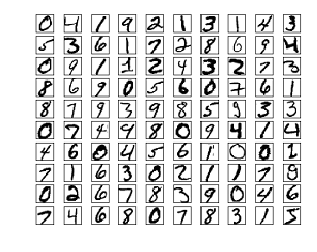

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('images/mnist_100_digits.png')
plt.axis('off')
imgplot = plt.imshow(img)

In [36]:
# Pulled this from the mnist_loader.py file to play a bit with the data
# before putting it through the network

f = gzip.open('./data/mnist.pkl.gz', 'rb')
training_data, validation_data, test_data = cPickle.load(f, encoding="latin1")
f.close()
training_images, training_labels = training_data
print("Number of training images and corresponding labels: ", len(training_images), len(training_labels))

Number of training images and corresponding labels:  50000 50000



Labels from the dataset:  4 8 2 6 (Indices: 2 31355 37214 30106 )


And the images themselves: 


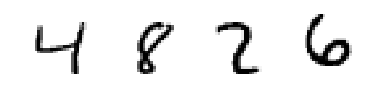

In [37]:
# Display a random image or choose your own number between [0, 50000)
index1 = 2 #random.randint(0, 50000)
index2 = random.randint(0, 50000)
index3 = random.randint(0, 50000)
index4 = random.randint(0, 50000)

# The images are stored in the pickle files as 784 (28x28) pixel long vectors. 
# We reshape them to their original dimensions
plt.subplot(1, 4, 1)
plt.imshow(training_images[index1].reshape(28, 28), cmap = 'binary')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(training_images[index2].reshape(28, 28), cmap = 'binary')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(training_images[index3].reshape(28, 28), cmap = 'binary')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(training_images[index4].reshape(28, 28), cmap = 'binary')
plt.axis('off')

print("\nLabels from the dataset: ", training_labels[index1], training_labels[index2], 
      training_labels[index3], training_labels[index4], 
     "(Indices:", index1, index2, index3, index4,")\n\n\nAnd the images themselves: ")


Label from the dataset:  2 (Index:7886)


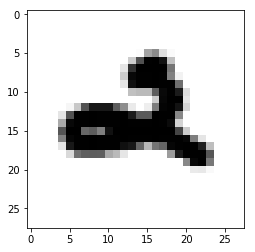

In [38]:
# Just for the heck of it, we can do this for the test dataset too
test_images, test_labels = test_data
index = random.randint(0, 10000)
plt.imshow(test_images[index].reshape(28, 28), cmap = 'binary')
print("\nLabel from the dataset: ", test_labels[index], "(Index:"+ str(index)+")")

## Ok, the datasets seem to be well-labeled.

In [40]:
# Developing a neural network from scratch
# Code from http://neuralnetworksanddeeplearning.com/chap1.html
# Modified to taste, with apologies to Michael Nielsen

import random as rnd
import numpy as np

class Network(object):
    def __init__(self, sizes): # Oh, class constructors!
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
            
        return a # Only the network output is returned
    
    def initial_test(self, test_data, i):
        test_data = list(test_data)
        
        score = self.evaluate(test_data)
        print("Test "+str(i)+":", score, "(",100*score/len(list(test_data)),"%)")
        
        
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None): # Stochastic Gradient Descent
        training_data = list(training_data)
        n = len(training_data)
        
        if test_data: 
            test_data = list(test_data)
            n_test = len(test_data)
        
        
        for j in range(epochs): # xrange in the original code has been deprecated in Python 3
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if(test_data):
                print("Epoch {}: {}/{}".format(j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {} complete".format(j))
                
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.weights = [w-(eta/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases =  [b-(eta/len(mini_batch))*nb for b, nb in zip(self.biases,  nabla_b)]
        
    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        activation = x
        
        activations = [x]
        
        zs = []
        
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        delta = self.cost_derivative(activations[-1], y)*sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta)*sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
            
        return (nabla_b, nabla_w)
    
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        
        return sum(int(x==y) for (x, y) in test_results)
    
    def cost_derivative(self, output_activations, y):
        return (output_activations - y)
    
    
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))     

def bad_classifications(network, test_data):
    misclassified = []
    
    for (x, ground_truth) in test_data:
        output = np.argmax(network.feedforward(x))
        if (output != ground_truth):
            misclassified += [(x, ground_truth, output)]
    
    return misclassified

In [41]:
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
test_data_copy = tuple(test_data)

## Let's begin by having a network initialized with random weights and biases predict what an digit is:

In [42]:
print("With random weights and biases in the network: ")

for i in range(10):
    net = Network([784, 30, 10])
    net.initial_test(test_data_copy, i+1)

With random weights and biases in the network: 
Test 1: 1182 ( 11.82 %)
Test 2: 1091 ( 10.91 %)
Test 3: 919 ( 9.19 %)
Test 4: 1027 ( 10.27 %)
Test 5: 1009 ( 10.09 %)
Test 6: 1023 ( 10.23 %)
Test 7: 785 ( 7.85 %)
Test 8: 724 ( 7.24 %)
Test 9: 1010 ( 10.1 %)
Test 10: 1087 ( 10.87 %)


### The network averages an error rate of close to 10%, which is expected of random chance prediction for this task. Using the last randomly initialized network, we begin training our network so that it actually learns.

In [43]:
print("Epoch #: (# of correctly identified digits)/(# of test images)")
net.SGD(training_data, 30, 10, 3.0, test_data=test_data_copy)

Epoch #: (# of correctly identified digits)/(# of test images)
Epoch 0: 8245/10000
Epoch 1: 9175/10000
Epoch 2: 9259/10000
Epoch 3: 9309/10000
Epoch 4: 9389/10000
Epoch 5: 9376/10000
Epoch 6: 9396/10000
Epoch 7: 9425/10000
Epoch 8: 9438/10000
Epoch 9: 9457/10000
Epoch 10: 9423/10000
Epoch 11: 9431/10000
Epoch 12: 9457/10000
Epoch 13: 9454/10000
Epoch 14: 9476/10000
Epoch 15: 9475/10000
Epoch 16: 9457/10000
Epoch 17: 9474/10000
Epoch 18: 9486/10000
Epoch 19: 9499/10000
Epoch 20: 9458/10000
Epoch 21: 9467/10000
Epoch 22: 9491/10000
Epoch 23: 9467/10000
Epoch 24: 9477/10000
Epoch 25: 9479/10000
Epoch 26: 9507/10000
Epoch 27: 9482/10000
Epoch 28: 9480/10000
Epoch 29: 9486/10000


Ground truth: 2 8 7 4 7 1 5 0 2 3 ; Predicted label: 5 5 9 9 0 8 6 6 7 7 


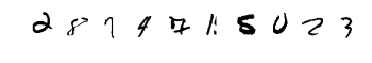

In [44]:
misclassified = bad_classifications(net, test_data_copy)

predicted_labels = "Predicted label: "
actual_labels = "Ground truth: "

n_examples = 10
for i in range(n_examples):
    index = random.randint(0, len(misclassified))
    (x, y, z) = misclassified[index]
    predicted_labels += str(z) + " "
    actual_labels += str(y) + " "
    plt.subplot(1, n_examples, i+1)
    plt.imshow(x.reshape(28, 28), cmap = 'binary')
    plt.axis('off')

print(actual_labels + "; " + predicted_labels)

## As can be seen in the examples above, some digits are actually hard to classify (1 and 7; 4 and 9; 6 and 8 are commonly confused). Others are less evident - 0s are often misclassified as 5s. Other techniques should be explored to improve the performance of this network.

## Yann LeCun has compiled a list of techniques and their corresponding test error rate ( http://yann.lecun.com/exdb/mnist/ ). CNNs have been demonstrated to perform with a less than 1% error rate. Compared to that, the above NN (structured as [784, 30, 30, 10]) averages an error rate of 5%. The next steps will hence be to develop a network that bridges this performance gap.

### Bonus: Testing out my own images with the trained neural network:

In [45]:
# Path where custom images to test can be added
# Images have to be 28 pixels x 28 pixels
filepath = 'my_images'
files = glob.glob(os.path.join(filepath, '*'))


Predicted label: 8 0 7 5 3 7 2 4 5 9 


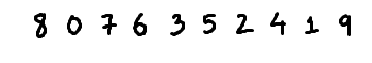

In [46]:
predicted_labels = "Predicted label: "
n_examples = len(files)
for i in range(n_examples):
    img = mpimg.imread(files[i])
    img = np.sum(img, axis=2)/3. # Flattening the image to remove RGB information
    img = 1-img # So that black pixels are 'hot', and the background is white.
    plt.subplot(1, n_examples, i+1)
    plt.imshow(img, cmap = 'binary')
    plt.axis('off')
    predicted_labels += str(np.argmax(net.feedforward(img.reshape(784, 1)))) + " "
    
print(predicted_labels)

## On these set of (relatively clean) images, the accuracy is only 70%. What gives?

When colors are inverted, predicted labels: 0 5 0 3 8 8 3 2 3 8 


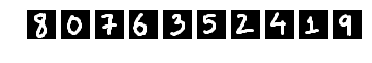

In [47]:
predicted_labels = "When colors are inverted, predicted labels: "
n_examples = len(files)
for i in range(n_examples):
    img = mpimg.imread(files[i])
    img = np.sum(img, axis=2)/3. # Flattening the image to remove RGB information
    #img = 1-img # So that black pixels are 'hot', and the background is white.
    plt.subplot(1, n_examples, i+1)
    plt.imshow(img, cmap = 'binary')
    plt.axis('off')
    predicted_labels += str(np.argmax(net.feedforward(img.reshape(784, 1)))) + " "
    
print(predicted_labels)

## Behold, the network behaves absolutely miserably when the colors are inverted!